# Concentraded Pools Study

Uniswap v3 is a noncustodial automated market maker implemented for the Ethereum Virtual Machine. In comparison to earlier versions of the protocol, Uniswap v3 provides increased capital efficiency and fine-tuned control to liquidity providers, improves the accuracy and convenience of the price oracle, and has a more flexible fee structure.[1] CFMMs as they are implemented today are often capital inefficient. In the constant product market maker formula used by Uniswap v1 and v2, only a fraction of the assets in the pool are
available at a given price. This is inefficient, particularly when assets are expected to trade close to a particular price at all times.


# Studying the WEN-SOL Token on Meterora

In [30]:
import requests
import pandas as pd

# API endpoint details
base_url = 'https://api.geckoterminal.com/api/v2'
endpoint = '/networks/{network}/pools/{pool_address}/ohlcv/{timeframe}'

# Headers for the API request
headers = {'Accept': 'application/json;version=20230302'}

# Parameters for the API request
params = {
    'network': 'solana',
    'pool_address': '5WGx6mE9Xww3ocYzSenGVQMJLCVVwK7ePnYV6cXcpJtK',
    'timeframe': 'minute',
    'aggregate': '5',
    'limit': '1000',
    'currency': 'token',
    'token': 'base'
}

# Form the URL
url = f"{base_url}{endpoint.format(network=params['network'], pool_address=params['pool_address'], timeframe=params['timeframe'])}"
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    ohlcv_list = data['data']['attributes']['ohlcv_list']
    df = pd.DataFrame(ohlcv_list, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    
else:
    print(f"Request failed with status code {response.status_code}")
    
df

,open,high,low,close,volume
timestamp,,,,,
2024-01-30 10:00:00,0.000001,0.000001,0.000001,0.000001,2.002490
2024-01-30 09:55:00,0.000001,0.000001,0.000001,0.000001,14.632940
2024-01-30 09:50:00,0.000001,0.000001,0.000001,0.000001,30.970021
2024-01-30 09:45:00,0.000001,0.000001,0.000001,0.000001,134.454591
2024-01-30 09:40:00,0.000001,0.000001,0.000001,0.000001,15.939805
...,...,...,...,...,...
2024-01-26 23:05:00,0.000001,0.000001,0.000001,0.000001,1402.467679
2024-01-26 23:00:00,0.000001,0.000001,0.000001,0.000001,2152.481675
2024-01-26 22:55:00,0.000001,0.000001,0.000001,0.000001,1724.124241


<Axes: title={'center': 'WEN - SOL - 5 minute candles'}, xlabel='timestamp'>

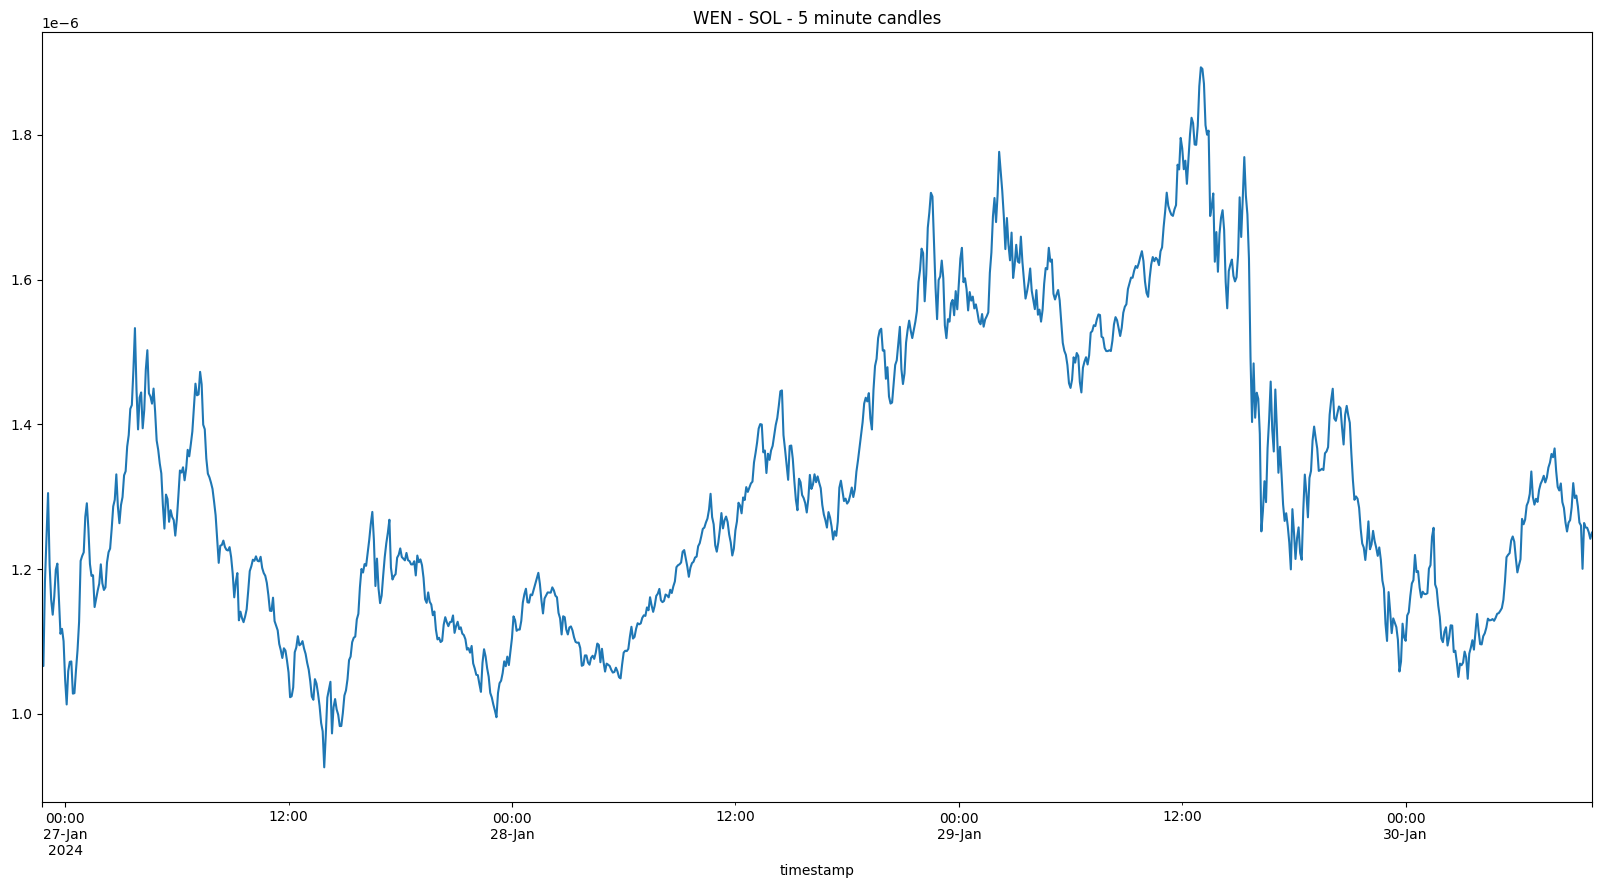

In [33]:
df.close.plot(figsize=(20,10), title='WEN - SOL - 5 minute candles')

# Expected Price ranges

ret: The return for each period.
avg: The average return over the last len periods.
gap: The high-low gap for each period.
avg_gap: The average high-low gap over the last len periods.
level: The level for each period, which is the average return of the previous period.
anchored_ret: The return anchored to the level.
sd_aret: The standard deviation of the anchored returns.
sd_up and sd_down: The upper and lower standard deviation levels.
sd_ehlg: The standard deviation of the high-low gap.
sd_upg and sd_downg: The upper and lower EHLG standard deviation levels.
arg_ic and arg_gap: Indicators for whether the close price is within the standard deviation levels.
arg_iron: The chosen indicator, based on whether the average gap is greater than the average return.
prob_ic: The probability of the iron condor, which is the mean of the chosen indicator over the last len periods.
You can use this function like this:

In [34]:
import numpy as np

def calculate_levels(df, len=5, per=84.1, dev_mult=2):
    # Calculate returns
    df['ret'] = np.where(df['close'] > df['open'], df['close'] - df['open'], df['open'] - df['close'])

    # Calculate average return
    df['avg'] = df['ret'].rolling(window=len).mean()

    # Calculate expected high-low gap
    df['gap'] = df['high'] - df['low']
    df['avg_gap'] = df['gap'].rolling(window=len).mean() / 2

    # Calculate levels
    df['level'] = df['avg'].shift(1)

    # Calculate standard deviation of returns
    df['anchored_ret'] = np.where(df['close'] > df['level'], df['close'] - df['level'], df['level'] - df['close'])
    df['sd_aret'] = df['anchored_ret'].rolling(window=len).std(ddof=0)

    # Calculate standard deviation levels
    df['sd_up'] = df['level'] + df['sd_aret'] * dev_mult
    df['sd_down'] = df['level'] - df['sd_aret'] * dev_mult

    # Calculate EHLG standard deviation levels
    df['sd_ehlg'] = df['gap'].rolling(window=len).std(ddof=0)
    df['sd_upg'] = df['level'] + df['sd_ehlg'] * dev_mult
    df['sd_downg'] = df['level'] - df['sd_ehlg'] * dev_mult

    # Calculate P(Iron Condor)
    df['arg_ic'] = np.where((df['close'] > df['sd_down']) & (df['close'] < df['sd_up']), 1, 0)
    df['arg_gap'] = np.where((df['close'] > df['sd_downg']) & (df['close'] < df['sd_upg']), 1, 0)
    df['arg_iron'] = np.where(df['avg_gap'] > df['avg'], df['arg_gap'], df['arg_ic'])
    df['prob_ic'] = df['arg_iron'].rolling(window=len).mean()

    return df

calculate_levels(df)

,open,high,low,close,volume,ret,avg,gap,avg_gap,level,...,sd_aret,sd_up,sd_down,sd_ehlg,sd_upg,sd_downg,arg_ic,arg_gap,arg_iron,prob_ic
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-30 10:00:00,0.000001,0.000001,0.000001,0.000001,2.002490,8.403291e-09,NaN,2.214576e-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2024-01-30 09:55:00,0.000001,0.000001,0.000001,0.000001,14.632940,9.086976e-09,NaN,1.761875e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2024-01-30 09:50:00,0.000001,0.000001,0.000001,0.000001,30.970021,6.061857e-09,NaN,1.235781e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2024-01-30 09:45:00,0.000001,0.000001,0.000001,0.000001,134.454591,4.588940e-10,NaN,4.570283e-08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN
2024-01-30 09:40:00,0.000001,0.000001,0.000001,0.000001,15.939805,6.184891e-09,6.039182e-09,1.401619e-08,9.191016e-09,NaN,...,NaN,NaN,NaN,1.458593e-08,NaN,NaN,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 23:05:00,0.000001,0.000001,0.000001,0.000001,1402.467679,6.192027e-08,5.096788e-08,1.233656e-07,5.787830e-08,4.600378e-08,...,5.471730e-08,1.554384e-07,-6.343081e-08,2.940310e-08,1.048100e-07,-1.280241e-08,0,0,0,0.0
2024-01-26 23:00:00,0.000001,0.000001,0.000001,0.000001,2152.481675,6.048496e-08,5.807004e-08,1.867845e-07,6.843634e-08,5.096788e-08,...,5.372064e-08,1.584092e-07,-5.647339e-08,3.448002e-08,1.199279e-07,-1.799217e-08,0,0,0,0.0
2024-01-26 22:55:00,0.000001,0.000001,0.000001,0.000001,1724.124241,1.164352e-07,7.715678e-08,1.667998e-07,7.214803e-08,5.807004e-08,...,4.875402e-08,1.555781e-07,-3.943799e-08,3.609091e-08,1.302519e-07,-1.411177e-08,0,0,0,0.0


<Axes: title={'center': 'WEN - SOL - 5 minute candles'}, xlabel='timestamp'>

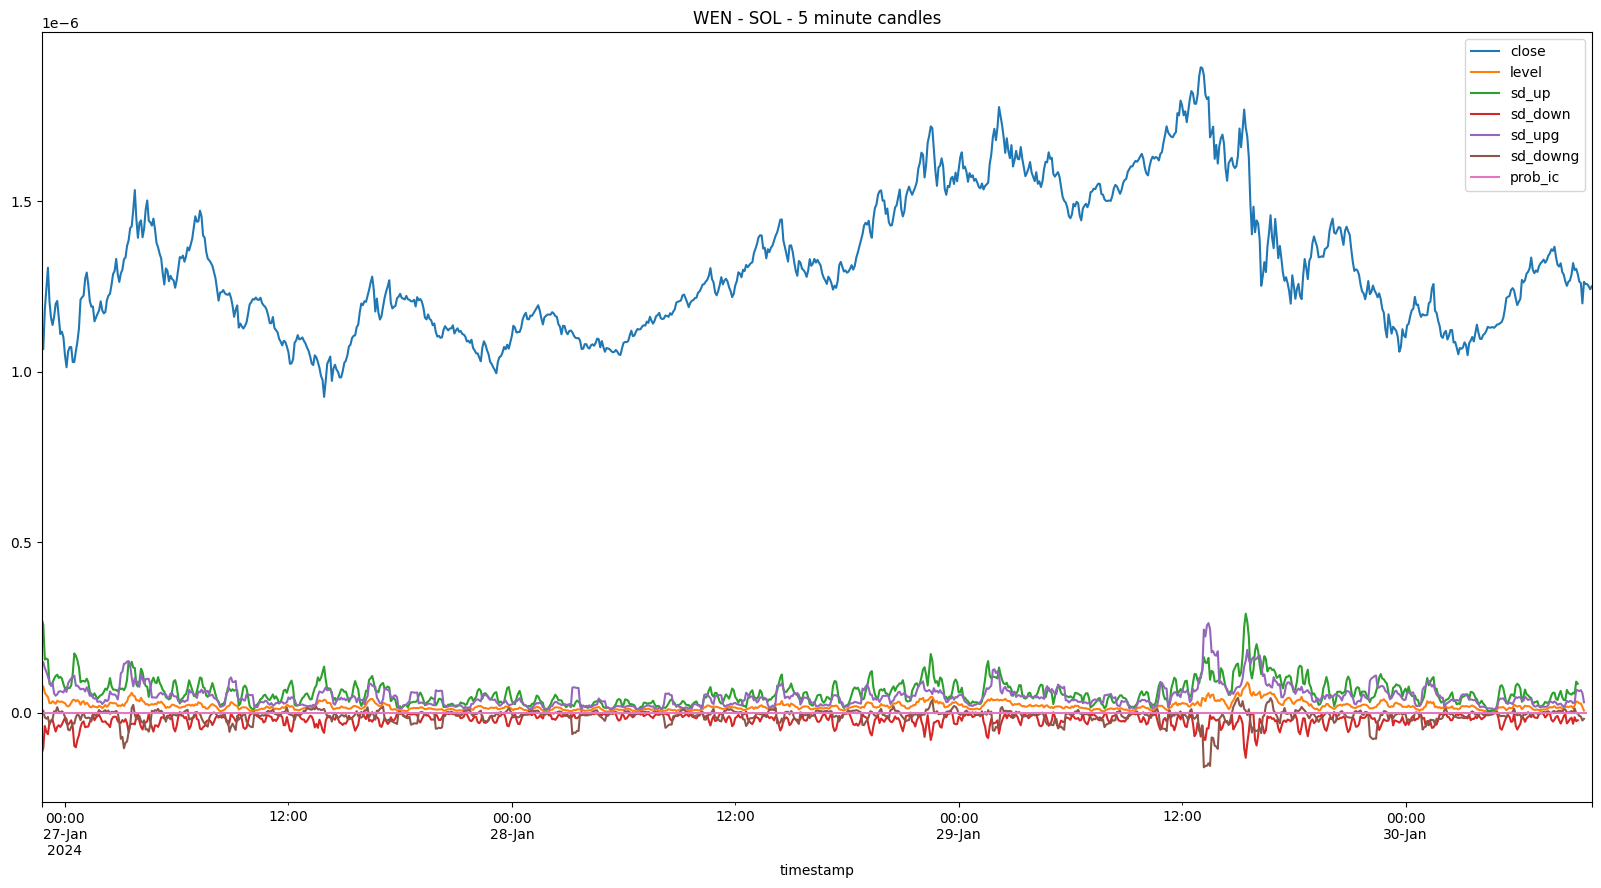

In [35]:
df[['close', 'level', 'sd_up', 'sd_down', 'sd_upg', 'sd_downg', 'prob_ic']].plot(figsize=(20,10), title='WEN - SOL - 5 minute candles')

# References:

[1] [Uniswap V3 Whitepaper](https://uniswap.org/whitepaper-v3.pdf)